### Retrieving the data

In [50]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.feature_selection import chi2
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline, make_pipeline

from collections import Counter

from nltk.sentiment import SentimentAnalyzer
from nltk.classify import NaiveBayesClassifier

import tensorflow as tf

from keras.callbacks import EarlyStopping, ModelCheckpoint

from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser

import transformers
import torch

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os

In [2]:
df = pd.read_csv("train.tsv", sep='\t', index_col="PhraseId")
pd.set_option('display.max_colwidth', None)
df.head(2)

,SentenceId,Phrase,Sentiment
PhraseId,,,
1,1,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",1
2,1,A series of escapades demonstrating the adage that what is good for the goose,2


In [3]:
train, test = train_test_split(df[["Phrase", "Sentiment"]], random_state=0)
X_train = train.Phrase
X_test = test.Phrase
y_train = train.Sentiment
y_test = test.Sentiment

In [4]:
def get_accuracy():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    return round(accuracy_score(y_pred, y_test),3)

### Baseline models



We'll build them through simple steps:

- encoding each sentence through basic methods such as bag of words and tf-idf.
- using classic trees ensembles that use bagging and boosting, respectively.
- ignoring the sentence Id.
- ignoring in some cases the less frequent words.

#### Random Forest, BOW, TF-IDF

In [5]:
count_vectorizer = CountVectorizer(max_features=1000)
random_forest = RandomForestClassifier(max_depth=10, n_estimators=10)

In [6]:
pipe = make_pipeline(count_vectorizer,random_forest)

In [7]:
get_accuracy()

0.515

Let's look at the percentages of the classes in the true labels and in the predictions. 

In [8]:
y_pred = pipe.predict(X_test)

In [9]:
round(pd.Series(y_train).value_counts(normalize=True),2)

2    0.51
3    0.21
1    0.17
4    0.06
0    0.04
Name: Sentiment, dtype: float64

In [10]:
round(pd.Series(y_pred).value_counts(normalize=True),2)

2    0.99
3    0.01
1    0.00
4    0.00
0    0.00
dtype: float64

As we can see, Decision Trees in their basic configuration are not a good model for unbalanced data! In almost every node, the biggest category has the majority and that's what the model predicts for almost every row. The accuracy then is aproximately the percentage of the biggest category: 0.5.

Let's add now weights.

In [11]:
random_forest.set_params(class_weight = 'balanced')
print(get_accuracy())
random_forest.set_params(class_weight = 'balanced_subsample')
print(get_accuracy())

0.481
0.443


Surprisingly or not, when using as weights the inverse of the classes proportion, the accuracy gets worst. 

Through the confusion matrix we can see that the model is still predicting _too much 2_, although now the complexity increased.

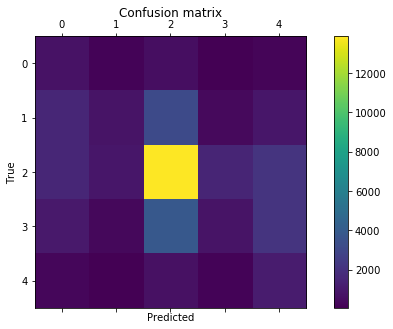

In [12]:
labels = [i for i in range(5)]
y_pred = pipe.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix')
fig.colorbar(cax)
ax.set_xticklabels(['']+ labels)
ax.set_yticklabels(['']+ labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

We'll try also adding lemmatization and replacing the BOW with tf-idf.

In [13]:
#taken from sklearn webpage
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

In [14]:
pipe[0].set_params(tokenizer=LemmaTokenizer())
get_accuracy()

0.46

In [15]:
tfidf_vectorizer = TfidfVectorizer()
pipe.steps[0] = ('vectorizer', tfidf_vectorizer)
get_accuracy()

0.434

That is, still poor results. We'll try with boosting.

#### Adaboost, chi2

In [16]:
ada_boost = AdaBoostClassifier()
pipe.steps[1] = ('adaboost', ada_boost)
get_accuracy()

0.541

We now see an improvement. We'll try now using only the most relevant words according to chi2.

In [ ]:
type()

In [ ]:
count_vectorizer.get_feature_names

In [21]:
count_vectorizer = CountVectorizer()

bow = count_vectorizer.fit_transform(X_train)

words = count_vectorizer.get_feature_names()

p_value_limit = 0.95

dtf_features = pd.DataFrame()

for cat in range(5):
    _, p = chi2(bow, y_train==cat)
    dtf_features = dtf_features.append(pd.DataFrame(
                   {"feature":words, "score":1-p, "y":cat}))
    dtf_features = dtf_features.sort_values(["y","score"], 
                    ascending=[True,False])
    dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
    
X_names = dtf_features["feature"].unique().tolist()

pipe['vectorizer'].set_params(vocabulary = X_names)

get_accuracy()

0.54

That is, similar than before. At this point, we are slightly better than a benchmark in Kaggle leaderbord, the one corresponding to predicting only _2/neutral_: 0.517.

- Why AdaBoost gave better results than Random Forest?
- Why AdaBoost predicted most of the times the majority class, but not always?

### Neural networks

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

We'll use a simple NN with only one hidden layer.

In [23]:
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [24]:
def fit_sequential(X_train, X_test, sequential=None, epochs=20, patience=5):
    
    if sequential is None:
        input_size = X_train.shape[1]

        sequential = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(input_size, )),
      tf.keras.layers.Dense(128, activation='sigmoid'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(5)
    ])
        loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        sequential.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])
        global mc
        mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
    
    es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=patience)    
    sequential.fit(X_train, np.array(y_train), epochs=epochs, verbose=1, validation_data=(X_test, np.array(y_test)), callbacks=[es, mc])
    sequential.load_weights('best_model.h5')
    return sequential

#### Using tf–idf

In [35]:
vectorizer = tfidf_vectorizer

In [36]:
X_train_vectorized = vectorizer.fit_transform(X_train) 
X_test_vectorized = vectorizer.transform(X_test)

In [37]:
sequential = fit_sequential(X_train_vectorized, X_test_vectorized)

Train on 117045 samples, validate on 39015 samples
Epoch 1/20
116864/117045 [============================>.] - ETA: 0s - loss: 1.2084 - accuracy: 0.5203
Epoch 00001: val_accuracy improved from -inf to 0.56132, saving model to best_model.h5
117045/117045 [==============================] - 48s 412us/sample - loss: 1.2082 - accuracy: 0.5204 - val_loss: 1.0444 - val_accuracy: 0.5613
Epoch 2/20
116992/117045 [============================>.] - ETA: 0s - loss: 0.9932 - accuracy: 0.5926
Epoch 00002: val_accuracy improved from 0.56132 to 0.62025, saving model to best_model.h5
117045/117045 [==============================] - 69s 589us/sample - loss: 0.9932 - accuracy: 0.5925 - val_loss: 0.9279 - val_accuracy: 0.6202
Epoch 3/20
117024/117045 [============================>.] - ETA: 0s - loss: 0.9035 - accuracy: 0.6295
Epoch 00003: val_accuracy improved from 0.62025 to 0.63624, saving model to best_model.h5
117045/117045 [==============================] - 56s 482us/sample - loss: 0.9035 - accuracy:

#### Using Word2vec

In [38]:
class W2VTransformer(BaseEstimator, TransformerMixin):
    def __init__( self, size):
        self.size = size
        pass
    
    def fit( self, X, y=None):
        self.model = Word2Vec(min_count=1,
                     window=2,
                     size=self.size,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20)
        sentences = [row.split() for row in X]
        
        self.model.build_vocab(sentences)
        self.model.train(sentences, total_examples=self.model.corpus_count, epochs=self.model.epochs)
        return self
        
    def get_vector(self, sentence):
        relevant_words_vectors = [self.model.wv[x] for x in sentence.split() if x in self.model.wv.vocab]
        if not relevant_words_vectors:
            return np.zeros(self.model.vector_size)#.astype('float32')
        return np.mean(relevant_words_vectors, axis=0)
    
    def transform( self, X):
        arr = np.array([])
        for elem in X:
            arr = np.concatenate([arr, self.get_vector(elem)])
        return arr.reshape(-1, self.size)

In [39]:
vectorizer = W2VTransformer(4)
X_train_vectorized = vectorizer.fit_transform(X_train) 
X_test_vectorized = vectorizer.transform(X_test)

In [41]:
sequential = fit_sequential(X_train_vectorized, X_test_vectorized)

Train on 117045 samples, validate on 39015 samples
Epoch 1/20
116864/117045 [============================>.] - ETA: 0s - loss: 1.2981 - accuracy: 0.5052
Epoch 00001: val_accuracy improved from -inf to 0.51214, saving model to best_model.h5
117045/117045 [==============================] - 7s 61us/sample - loss: 1.2981 - accuracy: 0.5052 - val_loss: 1.2759 - val_accuracy: 0.5121
Epoch 2/20
116640/117045 [============================>.] - ETA: 0s - loss: 1.2783 - accuracy: 0.5092
Epoch 00002: val_accuracy did not improve from 0.51214
117045/117045 [==============================] - 7s 58us/sample - loss: 1.2782 - accuracy: 0.5092 - val_loss: 1.2752 - val_accuracy: 0.5121
Epoch 3/20
116800/117045 [============================>.] - ETA: 0s - loss: 1.2745 - accuracy: 0.5092
Epoch 00003: val_accuracy did not improve from 0.51214
117045/117045 [==============================] - 7s 63us/sample - loss: 1.2745 - accuracy: 0.5092 - val_loss: 1.2723 - val_accuracy: 0.5120
Epoch 4/20
116352/117045 [

In [42]:
pca = PCA(n_components=2)
X_train_vectorized_2d = pca.fit_transform(X_train_vectorized)

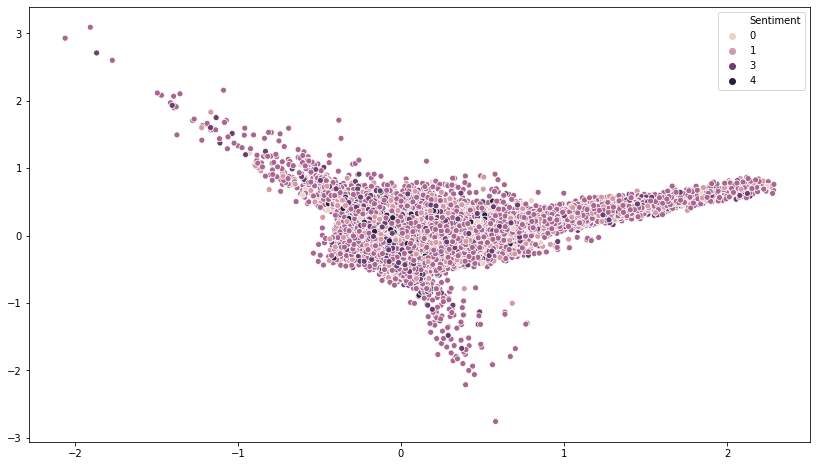

In [43]:
plt.figure(figsize=(14, 8))
_ = sns.scatterplot(X_train_vectorized_2d[:,0], X_train_vectorized_2d[:,1], hue=y_train)

Even though the scatterplot is not showing us the "neutral" points we can see that indeed there is not much of a separation between the classes

with the same preprocessing as before but using a neural network, the results are slightly better. It looks like we need to change the preprocessing in such a way that we start using the order between the words. A very first simple method, before we try more complex stuff like Word2Vec or LDA, would be adding 2-grams.

#### Using BERT

In [44]:
model_class, tokenizer_class, pretrained_weights = (transformers.DistilBertModel, transformers.DistilBertTokenizer, 'distilbert-base-uncased')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [47]:
kaggle_test = pd.read_csv("test.tsv", sep='\t', index_col="PhraseId")

all_sentences = X_train.append([X_test, kaggle_test.Phrase])

tokenized = all_sentences.apply(lambda x: tokenizer.encode(x, add_special_tokens=True))

max_len = max(tokenized.apply(len))
padded = np.array([row + [0]*(max_len-len(row)) for row in tokenized])

attention_mask = np.where(padded != 0, 1, 0)

input_ids = torch.tensor(padded)  
input_ids = torch.tensor(input_ids).to(torch.int64)

attention_mask = torch.tensor(attention_mask)

vector_length = model(input_ids[:1], attention_mask=attention_mask[:1])[0].shape[2]

vectors = np.zeros(shape=(0,vector_length))

C:\Users\Amos\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


We're using an already trained version of distilBERT. In order to create the embedding, this has to be done in batches.
For example through the below function:

In [48]:
def get_vectors():
    start = time.time()
    k=1000
    for i in range(0, len(all_sentences), k):
        with torch.no_grad():
            last_hidden_states = model(input_ids[i:i+k], attention_mask=input_ids[i:i+k])
        vectors = np.concatenate([vectors, last_hidden_states[0].numpy()[:,0,:]])
    return vectors

Doing so in a CPU can be highly time consuming (A way of speeding it up could be to use much less precision-numbers). I already saved the data.

In [53]:
file_name = "bert_vectors.csv"
if os.path.isfile(file_name):
    bert_vectors_df = pd.read_csv(file_name)
    vectors = bert_vectors_df.iloc[:,1:]
else:
    vectors = get_vectors()

In [54]:
X_train_vectorized = vectors[:len(X_train)]
X_test_vectorized = vectors[len(X_train):len(X_train)+len(X_test)]
kaggle_test_vectorized = vectors[len(X_train)+len(X_test):]

In [71]:
sequential = fit_sequential(X_train_vectorized, X_test_vectorized, sequential=sequential, epochs=10)

Train on 117045 samples, validate on 39015 samples
Epoch 1/10
116896/117045 [============================>.] - ETA: 0s - loss: 0.8369 - accuracy: 0.6523
Epoch 00001: val_accuracy did not improve from 0.64147
117045/117045 [==============================] - 12s 101us/sample - loss: 0.8368 - accuracy: 0.6523 - val_loss: 0.8577 - val_accuracy: 0.6407
Epoch 2/10
116512/117045 [============================>.] - ETA: 0s - loss: 0.8319 - accuracy: 0.6532
Epoch 00002: val_accuracy did not improve from 0.64147
117045/117045 [==============================] - 11s 96us/sample - loss: 0.8320 - accuracy: 0.6532 - val_loss: 0.8663 - val_accuracy: 0.6387
Epoch 3/10
116448/117045 [============================>.] - ETA: 0s - loss: 0.8271 - accuracy: 0.6563
Epoch 00003: val_accuracy improved from 0.64147 to 0.64273, saving model to best_model.h5
117045/117045 [==============================] - 11s 91us/sample - loss: 0.8270 - accuracy: 0.6564 - val_loss: 0.8567 - val_accuracy: 0.6427
Epoch 4/10
116608/1

We finally check the result in Kaggle Leaderboard.

In [70]:
predict = sequential.predict(kaggle_test_vectorized)
predict_max = np.argmax(predict, axis=1)
df_output = pd.DataFrame({"PhraseId":kaggle_test.index, "Sentiment":predict_max})
df_output.to_csv("submission.csv", index=False)

And it got an accuracy of 0.64917, that corresponds to the place 121 in Kaggle leaderboard.